In [1]:
from numpy.random import seed
seed(1)

In [2]:
!pip3 install nltk

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Note: Due to GPU-related randomness, the training will not be reproducible.

In [3]:
import keras
import pandas as pd
import numpy as np
import sklearn
import time
import tensorflow as tf
import matplotlib.pyplot as plt
tf.random.set_seed(10)
from LogisticRegressionModules import pre_processing as stopwords_stemmer

#### Load dataset from csv file.

In [4]:
df = pd.read_csv('./data/fake_or_real_news.csv')
df['merged_text'] = df['title'] + '. ' + df['text']

preprocessing_time_start = int(time.time())
df['processed_text'] = stopwords_stemmer(df['merged_text'])
preprocessing_time_end = int(time.time())
print(f'Preprocessing time: {preprocessing_time_end-preprocessing_time_start}sec')

# For no preprocessing, uncomment below
# df['processed_text'] = df['merged_text']

df.loc[df['label'] == 'REAL', 'target'] = 0
df.loc[df['label'] == 'FAKE', 'target'] = 1

df_pick = df[['processed_text', 'target']]
df.head()

Preprocessing time: 74sec


,Unnamed: 0,title,text,label,merged_text,processed_text,target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear. Daniel Greenfiel...,you can smell hillari ’ fear . daniel greenfie...,1.0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch the exact moment paul ryan commit polit ...,1.0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy. U...,kerri go pari gestur sympathi . u.s. secretari...,0.0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,berni support twitter erupt anger dnc : 'we tr...,1.0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,the battl new york : whi thi primari matter . ...,0.0


#### Load data as train and test data.   
  a. Add Title to Text and create the final text, label ordered pair.  
  b. Split the data 80-20 into train and test datasets.

In [5]:
training_data = df_pick.sample(frac=0.8, random_state=25)
testing_data = df_pick.drop(training_data.index)

print(training_data.shape)
print(testing_data.shape)

(5068, 2)
(1267, 2)


In [6]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_data['processed_text'].values, tf.string),
            tf.cast(training_data['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(testing_data['processed_text'].values, tf.string),
            tf.cast(testing_data['target'].values, tf.int32)
        )
    )
)
BUFFER_SIZE = 10000
BATCH_SIZE = 8
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-05-11 18:44:17.653758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 18:44:19.324865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30967 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


This is one training example in the dataset.

In [7]:
for example, label in training_dataset.take(1):
  print('texts: ', example.numpy()[:1])
  print('labels: ', label.numpy()[:1])

texts:  [b'\xe2\x80\x98 peopl europ full fear \xe2\x80\x99 refuge influx . the european union \xe2\x80\x99 sharpen divis spiral refuge crisi broke open thursday two leader strongli disagre public whether asylum-seek threaten \xe2\x80\x9c europ \xe2\x80\x99 christian roots. \xe2\x80\x9d that languag use hungarian prime minist viktor orban warn europ allow mostli muslim famili . a day drown syrian toddler wash turkish coast , anoth european leader retort christian valu demand help less fortun . the furiou exchang \xe2\x80\x94 rare breach e.u. \xe2\x80\x99 buttoned-down decorum \xe2\x80\x94 came hungarian author appar laid trap thousand asylum-seek pack budapest \xe2\x80\x99 central train station day worsen condit outsid station . polic block enter station day allow earli thursday . but refugee-pack train appar bound austrian border came halt west budapest , small town dozen polic offic wait platform . they tri forc peopl train take migrant-process center , threaten chanc make onward west

#### Define the Encoder layer

Note VOCAB_SIZE is a hyper-parameter. This layer will encode the input text as a sequence of integers indicating their indices in the vocabulary.

In [8]:
VOCAB_SIZE = 2000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda text, label: text))

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 125,   15,  758, ...,  684,    1, 1061],
       [   1,    1,  711, ...,    0,    0,    0],
       [ 682, 1211,    1, ...,    0,    0,    0]])

### Specify the model architecture
Layers:
1. Encoder
2. Embedding
3. LSTM
4. Dense layer
5. Output layer

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Trying out a sample text on untrained model.

In [12]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Training the model with Early Stopping
First, we specify the loss, optimizer, and metrics for the training phase.

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', f1_score])

To implement Early Stopping, we monitor the Validation Accuracy and do not stop training unless it doesn't increase above current highest for 7 epochs. Once it has stopped, we restore the model to its best weights according to the validation accuracy.

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
history = model.fit(training_dataset, epochs=20, callbacks = [callback],
                    validation_data=test_dataset)

Epoch 1/20
634/634 [==============================] - 30s 43ms/step - loss: 0.6322 - accuracy: 0.5951 - f1_score: 0.2747 - val_loss: 0.3872 - val_accuracy: 0.8106 - val_f1_score: 0.7461
Epoch 2/20
634/634 [==============================] - 26s 40ms/step - loss: 0.4005 - accuracy: 0.8498 - f1_score: 0.8375 - val_loss: 0.4543 - val_accuracy: 0.8366 - val_f1_score: 0.7913
Epoch 3/20
634/634 [==============================] - 26s 41ms/step - loss: 0.3260 - accuracy: 0.8812 - f1_score: 0.8544 - val_loss: 0.2939 - val_accuracy: 0.8792 - val_f1_score: 0.8462
Epoch 4/20
634/634 [==============================] - 26s 41ms/step - loss: 0.2151 - accuracy: 0.9140 - f1_score: 0.8877 - val_loss: 0.2464 - val_accuracy: 0.9006 - val_f1_score: 0.8712
Epoch 5/20
634/634 [==============================] - 26s 41ms/step - loss: 0.1605 - accuracy: 0.9426 - f1_score: 0.9282 - val_loss: 0.2209 - val_accuracy: 0.9163 - val_f1_score: 0.8845
Epoch 6/20
634/634 [==============================] - 25s 40ms/step - 

### Results

In [15]:
def plot_graphs(history, metric):
    """Utility function to plot the graphs"""
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

The plots below show the training accuracy and loss alongside the validation (here, validation set is the test set itself) accuracy and loss, plotted against the epoch number.

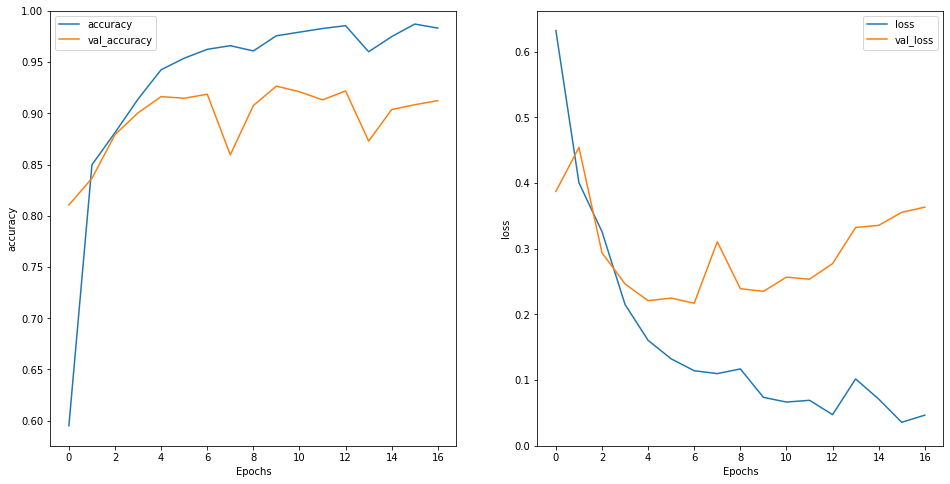

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig('plots/LSTM/LSTM_training_with_preprocessing')

### Test Accuracy and F1-Score of the trained LSTM classifier.

In [17]:
loss, accuracy, f1_score =model.evaluate(test_dataset)
results = dict(loss = loss, accuracy=accuracy, f1_score=f1_score)
import pickle
with open('outputs/LSTM_results_with_preprocessing.pkl', 'wb') as fout:
    pickle.dump(results, fout)
print(f'Test accuracy: {accuracy}\nTest loss: {loss}\nTest F1-score:{f1_score}')

159/159 [==============================] - 3s 20ms/step - loss: 0.2351 - accuracy: 0.9266 - f1_score: 0.9014
Test accuracy: 0.9265982508659363
Test loss: 0.23511315882205963
Test F1-score:0.9014349579811096
